# 🧪 U-Net pour détection de dislocations en images SEM (ECCI)
Notebook complet : importations, architecture, entraînement et évaluation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install segmentation_models_pytorch albumentations --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.2 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp


In [ ]:
class SEMDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.image_dir, self.images[idx]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(self.mask_dir, self.masks[idx]), cv2.IMREAD_GRAYSCALE)

        image = np.clip(image, np.percentile(image, 1), np.percentile(image, 99))
        image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
        image = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(image)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0).float() / 255


In [ ]:
transform = A.Compose([
    A.RandomGamma(p=0.5),                      # éclaircissement artificiel
    A.RandomBrightnessContrast(p=0.5),         # changement global du contraste
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),  # flou gaussien simulant bruit/instabilité
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=0.0, std=1.0, max_pixel_value=255.0),
    ToTensorV2()
])


image_dir = "/content/drive/MyDrive/unet/unet/patches/patches/patches/images"
mask_dir = "/content/drive/MyDrive/unet/unet/patches/patches/patches/masks"

train_dataset = SEMDataset(image_dir, mask_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


In [ ]:
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=1,
    classes=1,
    activation=None,
)
model = model.cuda() if torch.cuda.is_available() else model


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
import torch.nn.functional as F

def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

def focal_loss(pred, target, alpha=0.8, gamma=2):
    pred = torch.sigmoid(pred)
    bce = F.binary_cross_entropy(pred, target, reduction='mean')
    bce_exp = torch.exp(-bce)
    return alpha * (1 - bce_exp) ** gamma * bce

def combined_loss(pred, target):
    return dice_loss(pred, target) + focal_loss(pred, target)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(30):
    model.train()
    epoch_loss = 0
    for img, mask in train_loader:
        img, mask = img.cuda(), mask.cuda() if torch.cuda.is_available() else (img, mask)
        optimizer.zero_grad()
        output = model(img)
        loss = combined_loss(output, mask)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {epoch_loss/len(train_loader):.4f}")


Epoch 1 - Loss: 1.1234
Epoch 2 - Loss: 0.9849
Epoch 3 - Loss: 0.9162
Epoch 4 - Loss: 0.8775
Epoch 5 - Loss: 0.8516
Epoch 6 - Loss: 0.8299
Epoch 7 - Loss: 0.8067
Epoch 8 - Loss: 0.7802
Epoch 9 - Loss: 0.7580
Epoch 10 - Loss: 0.7443
Epoch 11 - Loss: 0.7268
Epoch 12 - Loss: 0.7012
Epoch 13 - Loss: 0.6869
Epoch 14 - Loss: 0.6606
Epoch 15 - Loss: 0.6398
Epoch 16 - Loss: 0.6258
Epoch 17 - Loss: 0.6054
Epoch 18 - Loss: 0.5810
Epoch 19 - Loss: 0.5592
Epoch 20 - Loss: 0.5450
Epoch 21 - Loss: 0.5316
Epoch 22 - Loss: 0.5065
Epoch 23 - Loss: 0.4888
Epoch 24 - Loss: 0.4770
Epoch 25 - Loss: 0.4562
Epoch 26 - Loss: 0.4469
Epoch 27 - Loss: 0.4289
Epoch 28 - Loss: 0.4172
Epoch 29 - Loss: 0.3972
Epoch 30 - Loss: 0.3810


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/unet_robuste_trained.pth")


Continuer l’entraînement (fine-tuning)

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm


In [ ]:
class SEMDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('patch_', 'patch_mask_').replace('.tif', '.png'))
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        return image, mask.unsqueeze(0) / 255.0


In [ ]:
transform = A.Compose([
    A.RandomGamma(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.0, contrast_limit=0.4, p=0.5),
    A.CLAHE(clip_limit=(2, 4), tile_grid_size=(8, 8), p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=0.0, std=1.0, max_pixel_value=255.0),
    ToTensorV2()
])


In [ ]:
image_dir = '/content/drive/MyDrive/unet/unet/patches_2/patches/images'
mask_dir = '/content/drive/MyDrive/unet/unet/patches_2/patches/masks'
dataset = SEMDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights=None,
    in_channels=1,
    classes=1,
    activation=None,
)
model_path = '/content/drive/MyDrive/unet_robuste_trained.pth'
model.load_state_dict(torch.load(model_path, map_location='cuda' if torch.cuda.is_available() else 'cpu'))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)


In [ ]:
# Fonctions de perte
dice_loss = smp.losses.DiceLoss(mode='binary')
focal_loss = smp.losses.FocalLoss('binary')

In [ ]:
# Entraînement
n_epochs = 20
for epoch in range(n_epochs):
    total_loss = 0
    for imgs, masks in tqdm(dataloader):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = dice_loss(preds, masks) + focal_loss(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss / len(dataloader):.4f}")

100%|██████████| 18/18 [01:16<00:00,  4.23s/it]


Epoch 1 - Loss: 0.6234


100%|██████████| 18/18 [00:01<00:00,  9.80it/s]


Epoch 2 - Loss: 0.6299


100%|██████████| 18/18 [00:01<00:00, 10.04it/s]


Epoch 3 - Loss: 0.6268


100%|██████████| 18/18 [00:01<00:00,  9.64it/s]


Epoch 4 - Loss: 0.6220


100%|██████████| 18/18 [00:01<00:00,  9.17it/s]


Epoch 5 - Loss: 0.6264


100%|██████████| 18/18 [00:01<00:00,  9.32it/s]


Epoch 6 - Loss: 0.6540


100%|██████████| 18/18 [00:01<00:00, 10.09it/s]


Epoch 7 - Loss: 0.6526


100%|██████████| 18/18 [00:01<00:00, 10.01it/s]


Epoch 8 - Loss: 0.6370


100%|██████████| 18/18 [00:01<00:00, 10.05it/s]


Epoch 9 - Loss: 0.6189


100%|██████████| 18/18 [00:01<00:00, 10.02it/s]


Epoch 10 - Loss: 0.6168


100%|██████████| 18/18 [00:01<00:00,  9.98it/s]


Epoch 11 - Loss: 0.6177


100%|██████████| 18/18 [00:01<00:00,  9.09it/s]


Epoch 12 - Loss: 0.6289


100%|██████████| 18/18 [00:01<00:00,  9.20it/s]


Epoch 13 - Loss: 0.6203


100%|██████████| 18/18 [00:01<00:00,  9.94it/s]


Epoch 14 - Loss: 0.6114


100%|██████████| 18/18 [00:01<00:00, 10.10it/s]


Epoch 15 - Loss: 0.6345


100%|██████████| 18/18 [00:01<00:00, 10.02it/s]


Epoch 16 - Loss: 0.6232


100%|██████████| 18/18 [00:01<00:00,  9.93it/s]


Epoch 17 - Loss: 0.6305


100%|██████████| 18/18 [00:01<00:00, 10.08it/s]


Epoch 18 - Loss: 0.6052


100%|██████████| 18/18 [00:01<00:00,  9.62it/s]


Epoch 19 - Loss: 0.6148


100%|██████████| 18/18 [00:01<00:00,  9.07it/s]

Epoch 20 - Loss: 0.6168


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/unet_robuste_trained_V2.pth')
print('✅ Modèle sauvegardé avec succès !')


✅ Modèle sauvegardé avec succès !


In [ ]:
!pip install segmentation_models_pytorch albumentations --quiet

Recadrage

In [ ]:
import os
from PIL import Image

# 📁 Chemins des dossiers
input_dir = "/content/drive/MyDrive/Images ECCI_ GaAs sur Si_17062025/Images ECCI_ GaAs sur Si_17062025"
output_dir = "/content/drive/MyDrive/Images ECCI_ GaAs sur Si_17062025/Images ECCI_ GaAs sur Si_17062025_cropped"
os.makedirs(output_dir, exist_ok=True)

# 🔁 Parcourir toutes les images .tif du dossier
for filename in os.listdir(input_dir):
    if filename.lower().endswith(".tif"):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        # Ouvrir et recadrer l'image
        image = Image.open(input_path)
        width, height = image.size
        cropped_image = image.crop((0, 0, width, height - 60))

        # Sauvegarder l'image recadrée
        cropped_image.save(output_path)

print("✅ Recadrage terminé. Fichiers enregistrés dans :", output_dir)


✅ Recadrage terminé. Fichiers enregistrés dans : /content/drive/MyDrive/Images ECCI_ GaAs sur Si_17062025/Images ECCI_ GaAs sur Si_17062025_cropped


**Prédiction**

In [21]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp


In [22]:
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = np.clip(image, np.percentile(image, 1), np.percentile(image, 99))
    image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
    image = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(image)
    return image


In [50]:
image_path = "/content/drive/MyDrive/Images ECCI_Ge sur SiGe_17062025/Images ECCI_Ge sur SiGe_17062025_cropped/SiGe_700nmGe_07.tif"
model_path = "/content/drive/MyDrive/unet_robuste_trained.pth"
output_dir = "/content/drive/MyDrive/dislocations/results2/"
os.makedirs(output_dir, exist_ok=True)


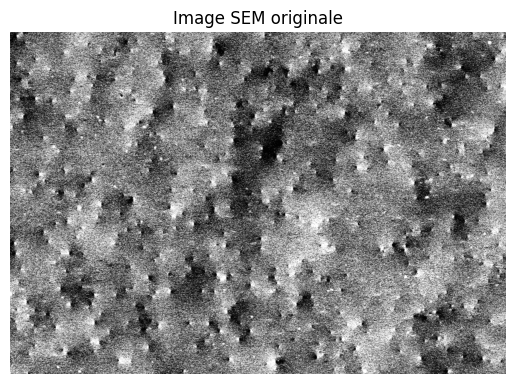

In [51]:
image = load_image(image_path)
h, w = image.shape
input_tensor = torch.tensor(image / 255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
input_tensor = input_tensor.cuda() if torch.cuda.is_available() else input_tensor

plt.imshow(image, cmap='gray')
plt.title("Image SEM originale")
plt.axis('off')
plt.show()


In [52]:
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights=None,
    in_channels=1,
    classes=1,
    activation=None,
)
model.load_state_dict(torch.load(model_path, map_location='cuda' if torch.cuda.is_available() else 'cpu'))
model = model.cuda() if torch.cuda.is_available() else model
model.eval()


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [53]:
with torch.no_grad():
    output = model(input_tensor)
    pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()


In [54]:
# ➕ Masque binaire
binary_mask = (pred_mask > 0.5).astype(np.uint8) * 255

# 💾 Sauvegarde du masque
mask_filename = os.path.basename(image_path).replace(".tif", "_pred_mask.png")
cv2.imwrite(os.path.join(output_dir, mask_filename), binary_mask)

# 🖍️ Overlay (rouge sur image)
image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
overlay = image_rgb.copy()
overlay[binary_mask > 0] = [255, 0, 0]
blended = cv2.addWeighted(overlay, 0.5, image_rgb, 0.5, 0)
overlay_filename = os.path.basename(image_path).replace(".tif", "_overlay.png")
cv2.imwrite(os.path.join(output_dir, overlay_filename), blended)

# 🔢 Comptage des dislocations
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
dislocation_count = 0
for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    if 2 <= area <= 150:
        dislocation_count += 1

# ✅ Résultat
print(f"✅ Masque sauvegardé sous : {os.path.join(output_dir, mask_filename)}")
print(f"✅ Overlay sauvegardé sous : {os.path.join(output_dir, overlay_filename)}")
print(f"🔬 Nombre de dislocations détectées : {dislocation_count}")


✅ Masque sauvegardé sous : /content/drive/MyDrive/dislocations/results2/SiGe_700nmGe_07_pred_mask.png
✅ Overlay sauvegardé sous : /content/drive/MyDrive/dislocations/results2/SiGe_700nmGe_07_overlay.png
🔬 Nombre de dislocations détectées : 589
